In [ ]:
!pip install pytorch-tabnet
!pip install wget
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 w

Скачивание набора данных об истории покупок электронной коммерции в магазине электроники

In [ ]:
train = pd.read_csv('1.csv')

Загрузка данных и разделение на 3 выборки для дальнейшей работы

In [ ]:
target = 'price'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
dataset_name = 'Table 1_1'

Простая предварительная обработка

Метки кодируют категориальные функции и заполняют пустые ячейки

In [ ]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Set 3


Определение категориальных признаков

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

# Список типа int индексов категориальных признаков
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# Список типа int, количество уникальных значений для категориального признака, новые модальности не могут быть предсказаны
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Список типа int размеров вложений для каждой категориальной функции (по умолчанию =1)
# Определение размеров: здесь просто случайный набор
cat_emb_dim = [5, 4, 3, 6, 2, 2, 9, 10]

Параметры нейронной сети

In [ ]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

train.head()

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


,order_id,product_id,category_id,price,user_id,Set
0,2.294360e+18,1.515966e+18,2.268105e+18,162.01,1.515916e+18,1
1,2.294360e+18,1.515966e+18,2.268105e+18,162.01,1.515916e+18,1
2,2.294444e+18,2.273948e+18,2.268105e+18,77.52,1.515916e+18,1
3,2.294444e+18,2.273948e+18,2.268105e+18,77.52,1.515916e+18,1
4,2.294584e+18,2.273948e+18,2.268105e+18,217.57,1.515916e+18,1


### Обучение

In [ ]:
# np.массив особенностей обучения
X_train = train[features].values[train_indices]
# y_train - np.массив учебных целей
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [ ]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [ ]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    # Cписок оцениваемых наборов кортежей (X, y)
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    # Список строковых наборов имен eval
    eval_name=['train', 'valid'],
    # Список показателей оценки
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    # Целое число (по умолчанию = 200)
    max_epochs=max_epochs,
    # Количество последовательных периодов без улучшения перед выполнением ранней остановки
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: inf     | train_rmsle: 193.92897| train_mae: 3.293602909253039e+17| train_rmse: 8.776790245045029e+17| train_mse: 7.703204700551757e+35| valid_rmsle: 198.50468| valid_mae: 3.374222618635162e+17| valid_rmse: 8.883558502276678e+17| valid_mse: 7.891761166337227e+35|  0:00:07s
epoch 1  | loss: nan     | train_rmsle: 199.72051| train_mae: 3.293602909253039e+17| train_rmse: 8.776790245045033e+17| train_mse: 7.703204700551763e+35| valid_rmsle: 204.52351| valid_mae: 3.3742226186351616e+17| valid_rmse: 8.883558502276681e+17| valid_mse: 7.891761166337232e+35|  0:00:12s
epoch 2  | loss: nan     | train_rmsle: 207.11418| train_mae: 3.293602909253039e+17| train_rmse: 8.776790245045033e+17| train_mse: 7.703204700551763e+35| valid_rmsle: 212.10549| valid_mae: 3.3742226186351616e+17| valid_rmse: 8.883558502276681e+17| valid_mse: 7.891761166337232e+35|  0:00:22s
epoch 3  | loss: nan     | train_rmsle: 215.64357| train_mae: 3.293602909253039e+17| train_rmse: 8.776790245045033e+17| train

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"ЛУЧШАЯ ПРАВИЛЬНАЯ ОЦЕНКА ДЛЯ {dataset_name} : {clf.best_cost}")
print(f"ФИНАЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ {dataset_name} : {test_score}")

ЛУЧШАЯ ПРАВИЛЬНАЯ ОЦЕНКА ДЛЯ Table 1_1 : 7.891761166337227e+35
ФИНАЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ Table 1_1 : 7.677328404783293e+35


### Сохранение модели и загрузка

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"ОКОНЧАТЕЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ {dataset_name} : {loaded_test_mse}")

ОКОНЧАТЕЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ Table 1_1 : 7.677328404783293e+35


In [ ]:
assert(test_score == loaded_test_mse)

### Нахождение вектора "важностей" признаков

In [ ]:
clf.feature_importances_

array([7.31913695e-01, 1.27315290e-04, 1.69693012e-01, 9.82659777e-02])

### Локальное линейное приближение поведения модели и маски

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

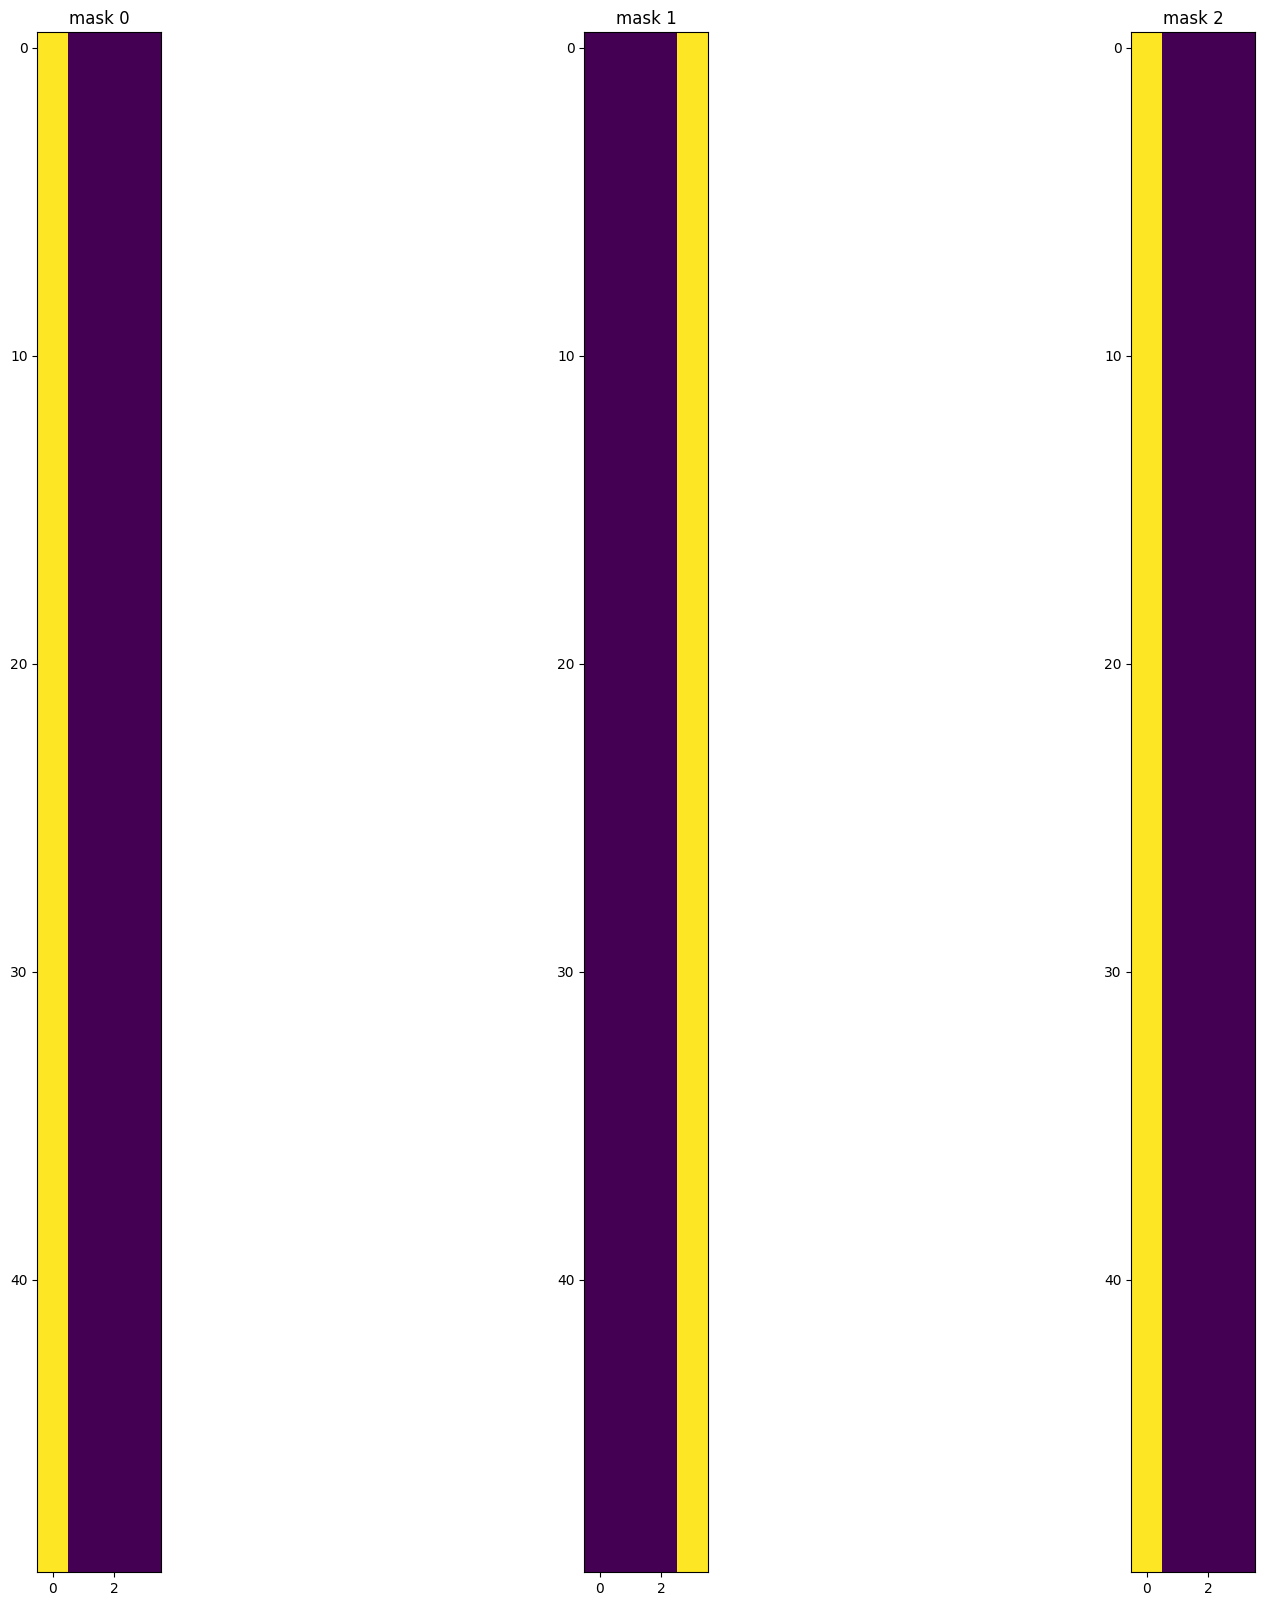

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

XGB - алгоритм машинного обучения, основанный на дереве поиска решений и использующий фреймворк градиентного бустинга

In [ ]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:876359301528936192.00000
[10]	validation_0-rmse:829223553626008576.00000


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:822996706444069760.00000
[30]	validation_0-rmse:822042673067186048.00000
[40]	validation_0-rmse:821886040418591360.00000
[50]	validation_0-rmse:821832515814413056.00000
[60]	validation_0-rmse:821816560206268544.00000
[70]	validation_0-rmse:821810436664924288.00000
[80]	validation_0-rmse:821778160365292800.00000
[90]	validation_0-rmse:821786725698317952.00000
[100]	validation_0-rmse:821776843533472256.00000
[110]	validation_0-rmse:821766752225932416.00000
[120]	validation_0-rmse:821767170385641472.00000
[130]	validation_0-rmse:821741070391766144.00000
[140]	validation_0-rmse:821739561818098560.00000
[150]	validation_0-rmse:821743341771411968.00000
[160]	validation_0-rmse:821740211363905152.00000
[170]	validation_0-rmse:821744955851864192.00000
[174]	validation_0-rmse:821739123750758784.00000


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
preds = np.array(clf_xgb.predict(X_valid))
# Измеряет среднюю сумму квадратной разности между фактическим значением и прогнозируемым значением для всех точек
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

6.752482341282156e+35
6.598607748185121e+35
